In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns
import matplotlib
%matplotlib inline
plt.style.use('seaborn')

## Set Fonts for plots

In [68]:
text_size = 12
matplotlib.rc('xtick', labelsize = text_size)
matplotlib.rc('ytick', labelsize = text_size)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

## Read Clean Data

In [3]:
df = pd.read_csv('../data/cleaned_data.zip')

df.drop('Unnamed: 0', axis=1, inplace=True)

df.drop_duplicates('project_id', keep='first', inplace=True)

# Univariate Plots

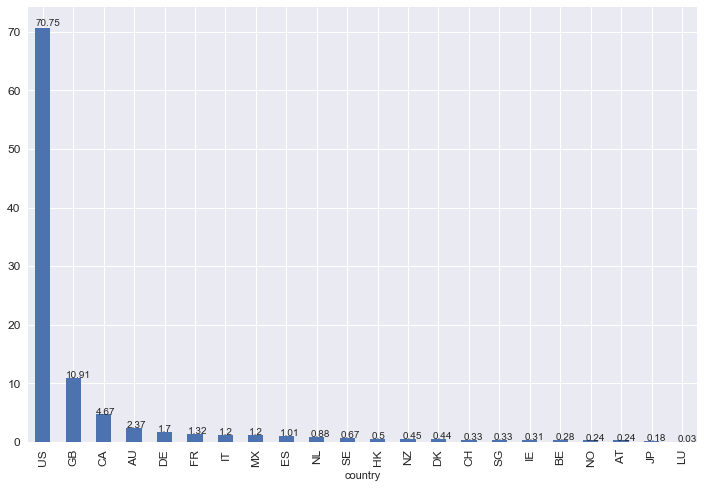

In [14]:
temp_series = df.groupby('country').size()
ax = (temp_series.sort_values(ascending=False)/temp_series.sum() * 100.0).plot(kind='bar',figsize=(12,8))
for p in ax.patches:
    ax.annotate(str(round(p.get_height(),2)), (p.get_x() * 1.005, p.get_height() * 1.005))

- Over 70% projects are from the US, about 7 times more than Great Britain which has about 11%

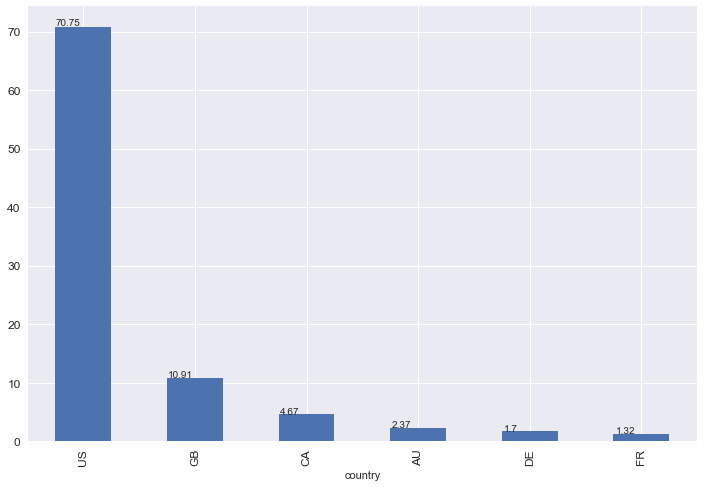

In [15]:
temp_series = df.groupby('country').size()
ax = (temp_series.sort_values(ascending=False)[:6]/temp_series.sum() * 100.0).plot(kind='bar',figsize=(12,8))
for p in ax.patches:
    ax.annotate(str(round(p.get_height(),2)), (p.get_x() * 1.005, p.get_height() * 1.005))

#### Create a US dataframe

In [20]:
us = df[df['country']=='US']

us_states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

us = us[us['location_state'].isin(us_states)]

us = us[~us['location_state'].isnull()]

#### Top 5 categories in the US

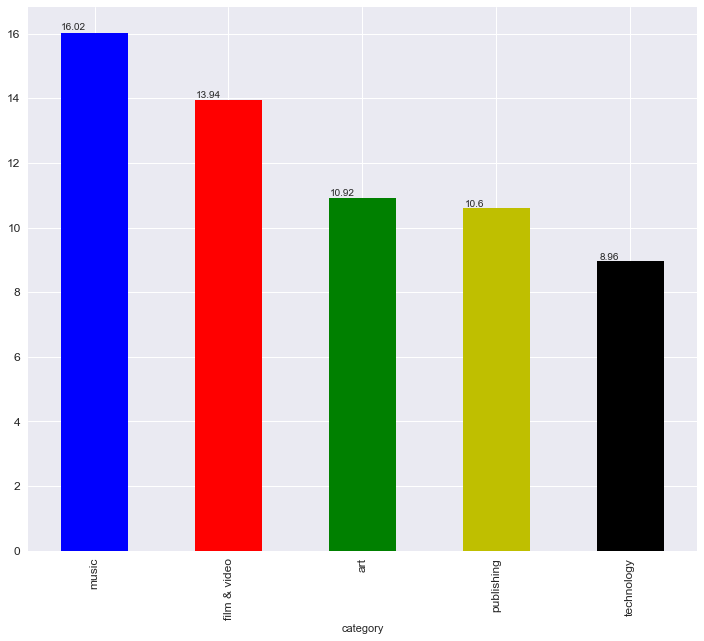

In [24]:
temp_series = us.groupby('category').size()
colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(temp_series)))
ax = (temp_series.sort_values(ascending=False)[:5]/temp_series.sum() * 100.0).\
        plot(kind='bar', figsize=(12,10), color = colors)

for p in ax.patches:
    ax.annotate(str(round(p.get_height(),2)), (p.get_x() * 1.005, p.get_height() * 1.005))

- It seems like projects are fairly distributed on kickstarter amongst the top categories
- The top 5 categories account for around 60% projects

### What percentage of projects are successful in the US

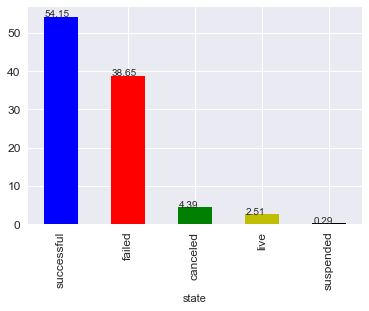

In [25]:
colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(temp_series)))
temp_series = ((us.groupby('state').size()/us.shape[0])*100).sort_values(ascending=False)
ax = temp_series.plot(kind='bar', color = colors)
for p in ax.patches:
    ax.annotate(str(round(p.get_height(),2)), (p.get_x() * 1.005, p.get_height() * 1.005))

- Slightly more than half of the projects listed succeed
- It would be a good execrise to look at the credentials of the projects that succeed
- They might suggest some subtle changes to improve chances for others

### What are the deadlines set by the creator to reach the goal amount

In [27]:
us['days_to_deadline'] = (pd.to_datetime(us['deadline']) - pd.to_datetime(us['launched_at'])).astype('timedelta64[D]')

us = us[~(us['days_to_deadline'] > 65)]

(array([ 1540.,  2754.,  9475.,  9242., 72595.,  9503.,  9884.,  2444.,
         1594., 11795.]),
 array([ 1. ,  7.4, 13.8, 20.2, 26.6, 33. , 39.4, 45.8, 52.2, 58.6, 65. ]),
 <a list of 10 Patch objects>)

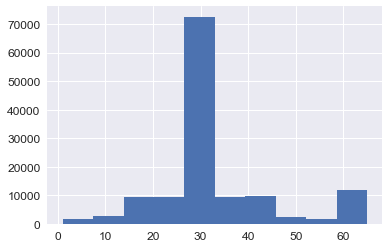

In [29]:
plt.hist(us['days_to_deadline'])

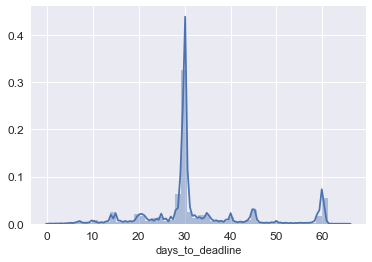

In [30]:
sns.distplot(us['days_to_deadline'], norm_hist=True)

In [31]:
us['days_to_deadline'].mode()

0    30.0
dtype: float64

In [32]:
### Explore the state when days to dead line > 30, < 30, = 30
def GroupColFunc(df, ind, col):
    if df[col].loc[ind] < 30:
        return 'less than 30'
    elif df[col].loc[ind] > 30:
        return 'greater than 30'
    else:
        return 'equal to 30'


In [33]:
us_grouped = us.groupby(lambda x: GroupColFunc(us, x, 'days_to_deadline'))

In [34]:
us_grouped.size()

equal to 30        54481
greater than 30    41399
less than 30       34946
dtype: int64

- Looks like most project have a deadline of a month
- Indeed projects with 30 days as deadline outnumber the projects with less than 30 days or more than 30 days

### Are most projects launched on Mondays, Tuesdays, or ...
#### Creating the variable now, would contrast the days in the bivariate section

In [ ]:
def get_day(d):
    return d.isoweekday()

In [40]:
us['launched_weekday'] = pd.to_datetime(us['launched_at']).apply(get_day)

### How long is the short description

In [42]:
def get_length_of_description(word):
    if pd.isnull(word):
        return 0
    return len(word)

In [43]:
us['description_length'] = us['blurb'].apply(get_length_of_description)

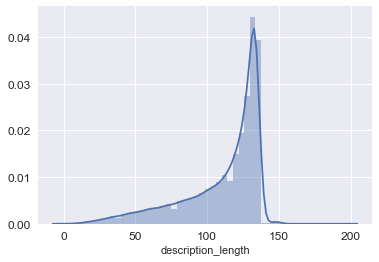

In [44]:
sns.distplot(us[us['state'] == 'successful']['description_length'], label='successful')

- Seems like most projects have a description length in the range of 120 and 140
- Would be interesting to see if it has any imapct on the success of a project

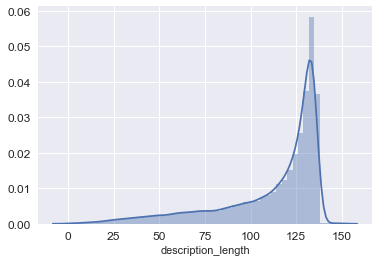

In [45]:
sns.distplot(us[(us['state'] != 'successful') & (us['state'] != 'live')]['description_length'])

- Indeed for successful projects the curve has moved to the right

In [46]:
us['description_length'].describe()

count    130826.000000
mean        110.757999
std          28.254766
min           0.000000
25%          98.000000
50%         123.000000
75%         132.000000
max         196.000000
Name: description_length, dtype: float64

In [47]:
round(np.sum(us['description_length'] > 140)/us.shape[0]*100, 2)

0.28

- Only 28% of projects have a length greater than 140 characters

### What is the spread of the spotlight variable

In [48]:
us['spotlight'].value_counts()

1.0    70808
0.0    60018
Name: spotlight, dtype: int64

- An egalitarian spread

### The top 20 sub categories

In [74]:
us[us['sub_category'].isnull()]['state'].value_counts()

successful    5477
live           692
failed         128
Name: state, dtype: int64

In [75]:
us.loc[us['sub_category'].isnull(), 'sub_category'] = 'missing'

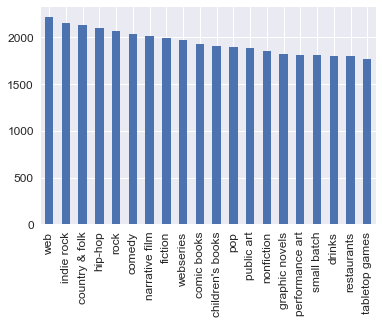

In [71]:
us['sub_category'].value_counts(ascending=False)[:20].plot(kind='bar')

- The curve appears as if it is almost consistent accross the top 20 sub categories

### Visualizing the category parent

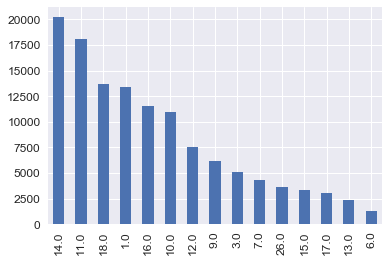

In [72]:
us['category_parent_id'].value_counts().plot(kind='bar')

- We do observe variability here
- Would analyse its impact on the success of a project

### Look at the spread of category position

In [78]:
us['category_position'].value_counts()

3.0     14282
5.0     12860
4.0     12561
2.0     10857
7.0      9467
6.0      9061
8.0      8780
9.0      8365
10.0     8293
1.0      8199
14.0     5075
11.0     4698
13.0     3176
12.0     3092
17.0     3002
15.0     2755
18.0     2344
16.0     1981
19.0     1978
Name: category_position, dtype: int64

### What percentage of creators are unique

In [80]:
round(len(us['creator_name'].unique())/us.shape[0] * 100,2)

83.56

- Around 84% of creators are unique

In [81]:
us['creator_name'].value_counts(ascending = False)

"Collectable Playing Cards"                                69
"GBS Detroit","slug":"gbsdetroit"                          52
"Michael"                                                  45
"David"                                                    41
"David Walsh","slug":"davidwalshbowlmaker"                 38
"badgirlartwork.com","slug":"badgirlartwork"               36
"Evolutionary Comics"                                      35
"Jose Pulido"                                              32
"Mary & Josh","slug":"jlplive"                             31
"HooligansCO","slug":"hooligansco"                         31
"Chris"                                                    31
"John Rap","slug":"johnrap"                                30
"Michele Hartsoe"                                          30
"Jessica Feinberg","slug":"jessicafeinberg"                27
"John Daniel Taylor IV"                                    26
"James"                                                    26
"Andrew"

- Looking at the spread, it doesn't appear if this would be a useful variable in our analysis

### How does the distribution of goal look like

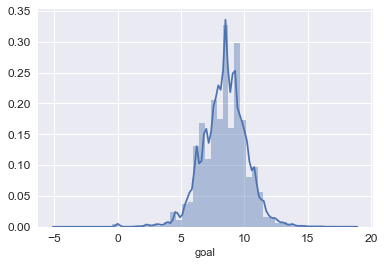

In [86]:
sns.distplot(np.log(us['goal']))

#### Let's see how do the successful projects set their goals

In [87]:
us_successful = us[us['state'] == 'successful']

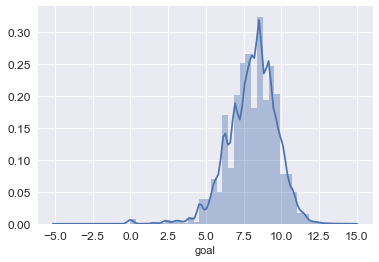

In [69]:
sns.distplot(np.log(us_successful['goal']))

- Looks like as a creator you'd want to set an optimal moderate goal amount
- Perhaps in between 10,000 USD to 45,000 USD
- Looks like an important variable to further our analysis

### And now the ones that failed

In [88]:
us_failed = us[(us['state'] != 'successful') & (us['state'] != 'live') ]

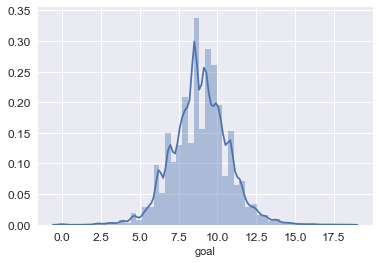

In [89]:
sns.distplot(np.log(us_failed['goal']))

- Too high doesn't work
- Too low doesn't work either

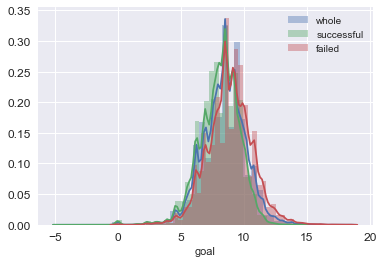

In [90]:
sns.distplot(np.log(us['goal']), label='whole')
sns.distplot(np.log(us_successful['goal']), label='successful')
sns.distplot(np.log(us_failed['goal']), label='failed')
plt.legend()

### When does the state of a project change

In [91]:
np.argmax((np.abs((pd.to_datetime(us['deadline']) - pd.to_datetime(us['state_changed_at'])).astype('timedelta64[s]'))).value_counts())

C:\Users\sahil\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


0.0

- Looks like most changes are around the deadline

### Some transformations to create variables from project launch date

In [71]:
us['launched_at'] = pd.to_datetime(us['launched_at'])

In [72]:
## launched month
us['launched_month'] = us['launched_at'].dt.month

In [73]:
## launched week
us['launched_week'] = us['launched_at'].dt.week

### Was the project launched over a weekend

In [74]:
us['is_weekend_launch'] = us['launched_weekday'].apply(lambda x: x > 4)

### What about the word count of the short description

In [78]:
us['description_word_count'] = us['blurb'].fillna("").apply(lambda x: len(x.split()))

In [167]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [168]:
def clean_words (word):
    word = word.lower()
    word_list = word.split()
    clean_words = [word for word in word_list if not word.isdigit()]
    return " ".join(clean_words)

In [169]:
us['cleaned_description'] = us['blurb'].fillna("").apply(clean_words)

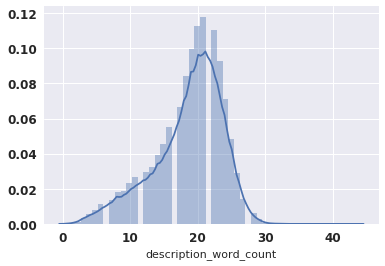

In [79]:
sns.distplot(us[us['state'] == 'successful']['description_word_count'], label='successful')

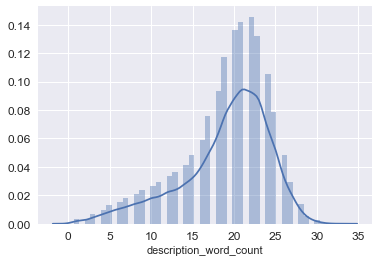

In [184]:
sns.distplot(us[(us['state'] != 'successful') & (us['state'] != 'live')]['description_word_count'], label='failed')

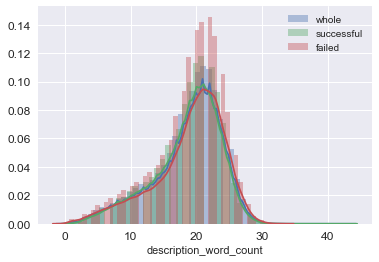

In [185]:
sns.distplot(us['description_word_count'], label='whole')
sns.distplot(us[us['state'] == 'successful']['description_word_count'], label='successful')
sns.distplot(us[(us['state'] != 'successful') & (us['state'] != 'live')]['description_word_count'], label='failed')
plt.legend()

- Successful projects have a moderate word count
- Appears as if the word count is consistent accross successful and failed projects

## Bivariate Analysis

### How do backers back by category

<Figure size 1080x864 with 0 Axes>

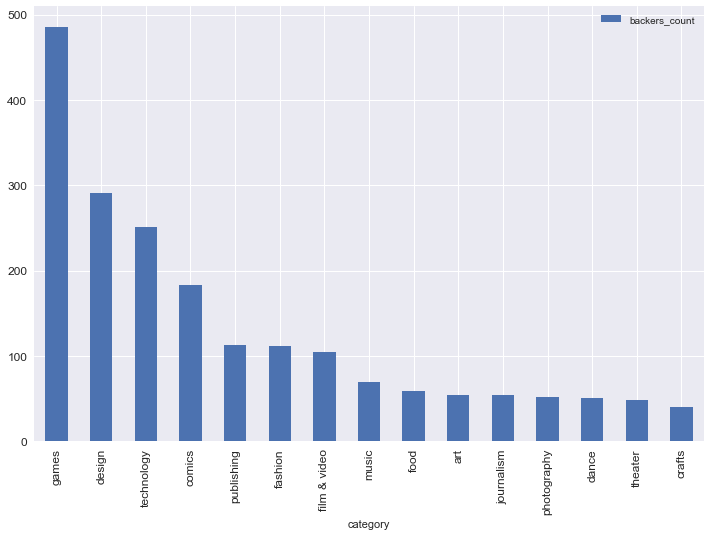

In [9]:
plt.figure(figsize=(15,12))
df[['category', 'backers_count']].groupby('category').mean().sort_values(by='backers_count', ascending=False).plot(kind='bar',\
                                                                                        figsize=(12,8))

- Well spread out
- games category has most of the backers

### Pledged with category

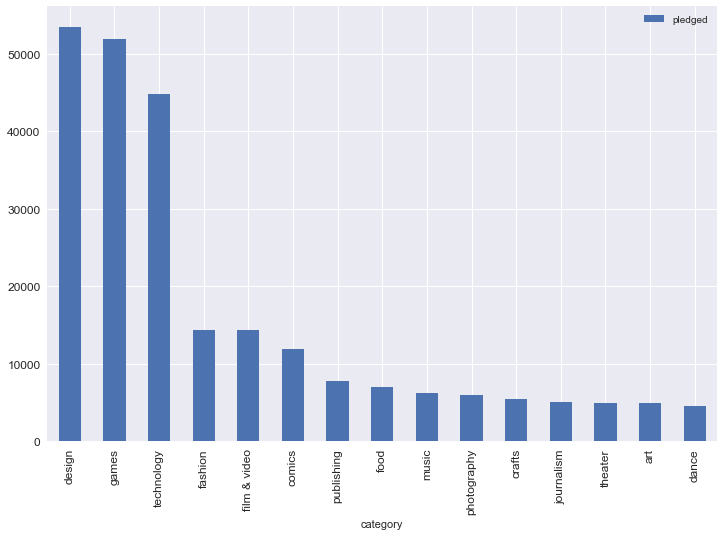

In [10]:
df[['category', 'pledged']].groupby('category').mean().sort_values(by='pledged', ascending=False).plot(kind='bar',\
                                                                                        figsize=(12,8))

- design has slightly more pledged count than games
- that's interesting

### Backers count with State

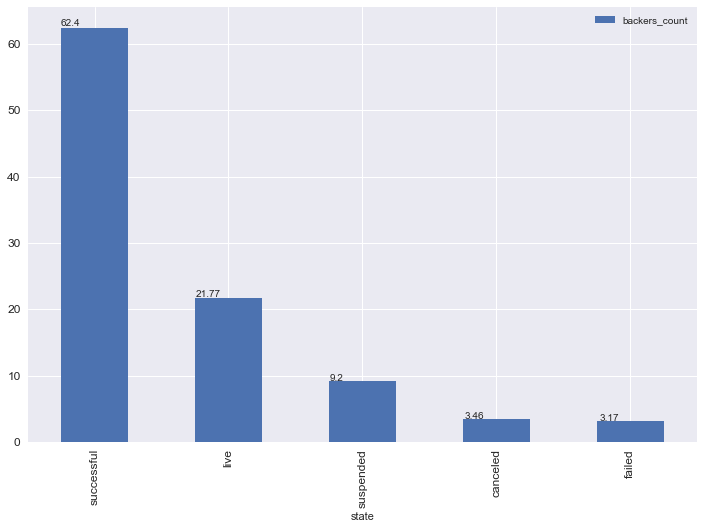

In [12]:
temp_df = df[['state', 'backers_count']].groupby('state').mean()
ax = (temp_df.sort_values(by='backers_count', ascending=False)/(temp_df['backers_count'].sum())*100).\
        plot(kind='bar',figsize=(12,8))

for p in ax.patches:
    ax.annotate(str(round(p.get_height(),2)), (p.get_x() * 1.005, p.get_height() * 1.005))

- successful projects dominate as expected
- backers count would be a useful variable if the spread were given over time
- Over a snapshot, though it might not be as useful for learning the credentials of a succesful project that would help in improving the chances of sucess for others
- One of the goal appears to be raising the backers count number

### Pledged count with State

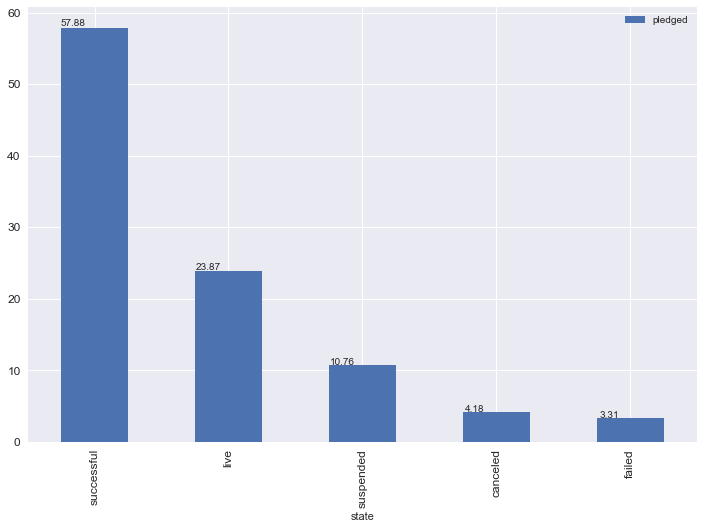

In [13]:
temp_df = df[['state', 'pledged']].groupby('state').mean()
ax = (temp_df.sort_values(by='pledged', ascending=False)/temp_df['pledged'].sum() * 100.0).plot(kind='bar',figsize=(12,8))
for p in ax.patches:
    ax.annotate(str(round(p.get_height(),2)), (p.get_x() * 1.005, p.get_height() * 1.005))

- same observation as for backers count
- pledged count is a goal variable rather

### Category by Countries

In [16]:
countries = df.groupby('country').size().sort_values(ascending=False)[:6].index

In [17]:
sub_df = df[df['country'].isin(countries)].groupby(['country','category']).size().unstack()

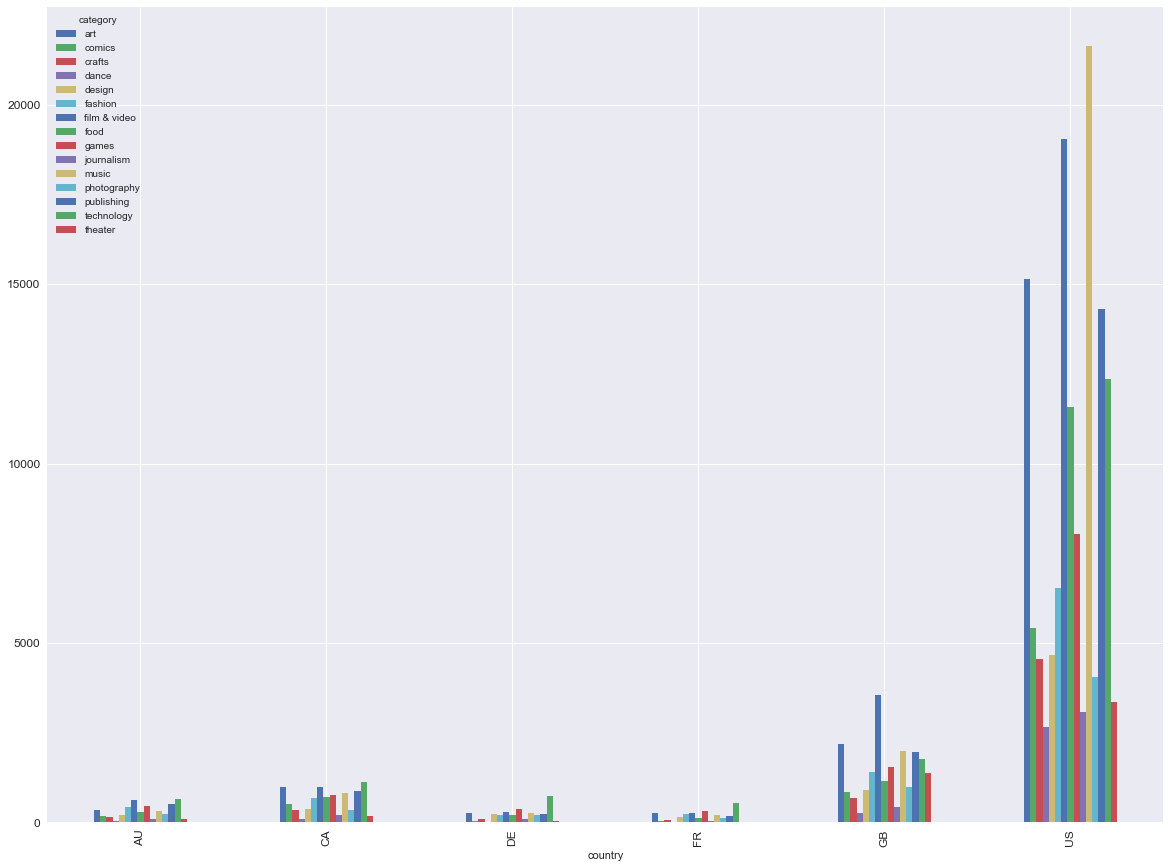

In [18]:
sub_df.plot(kind='bar', figsize=(20, 15))

- US dwarfs all other nations in all of the categories

### Top 5 categories with Top 6 Countries

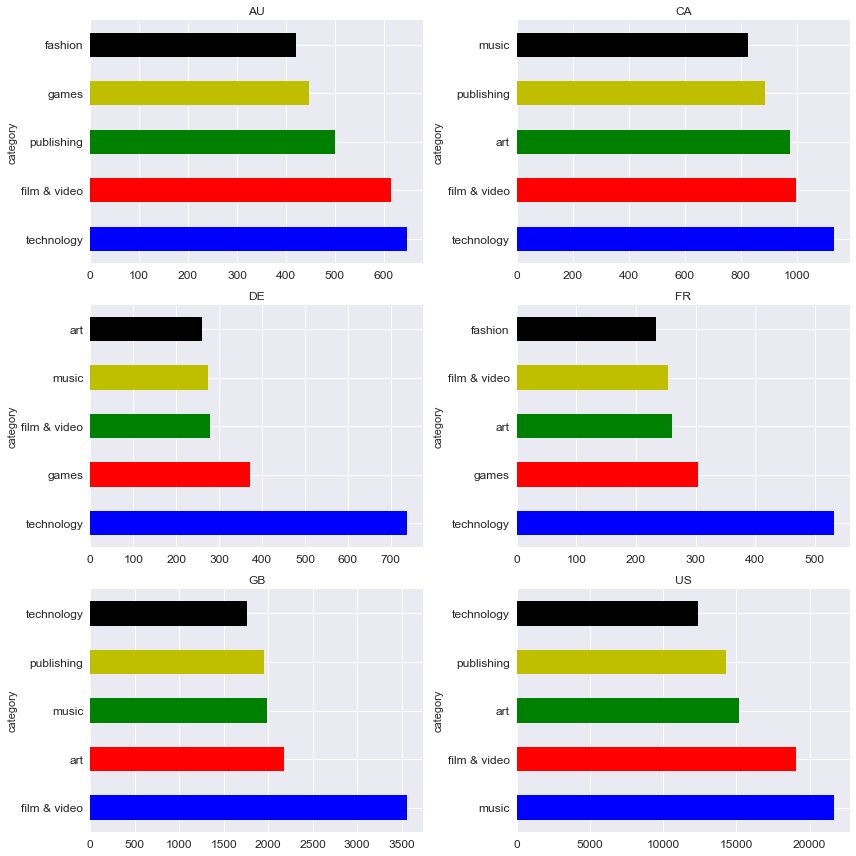

In [19]:
from itertools import cycle, islice
%matplotlib inline
COL_NUM = 2
ROW_NUM = 3
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(12,12))
colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(sub_df)))
for i, (borough, agency_count) in enumerate(sub_df.transpose().items()): 
    ax = axes[int(i/COL_NUM), i%COL_NUM]
    agency_count = agency_count.sort_values(ascending=False)[:5] 
    agency_count.plot(kind='barh', ax=ax, color = colors)
    ax.set_title(borough)

plt.tight_layout() 

- Germany, France, Canada, and Australia have technology as the top category
- Britain, and the US are dominated by film, art, and music

### How do days affect the chances of success

In [35]:
us['days_status'] = np.where(us['days_to_deadline'] < 30, 'less', \
                             np.where(us['days_to_deadline'] > 30, 'greater', 'equal'))

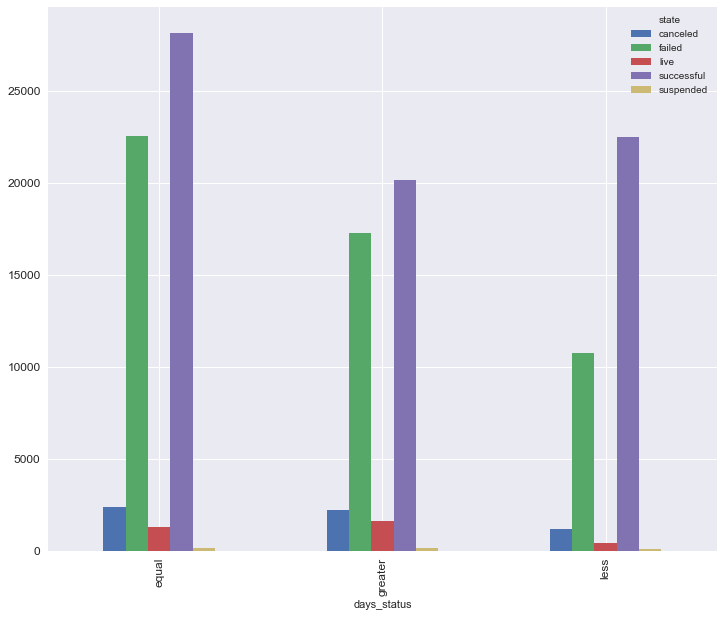

In [36]:
us.groupby(['days_status', 'state']).size().unstack().plot(kind='bar', figsize=(12,10))

- Moderate deadlines seem to be contributing factor

### Success by Category

In [37]:
us_sub = us[us['category'].isin(us['category'].value_counts()[:5].index)]

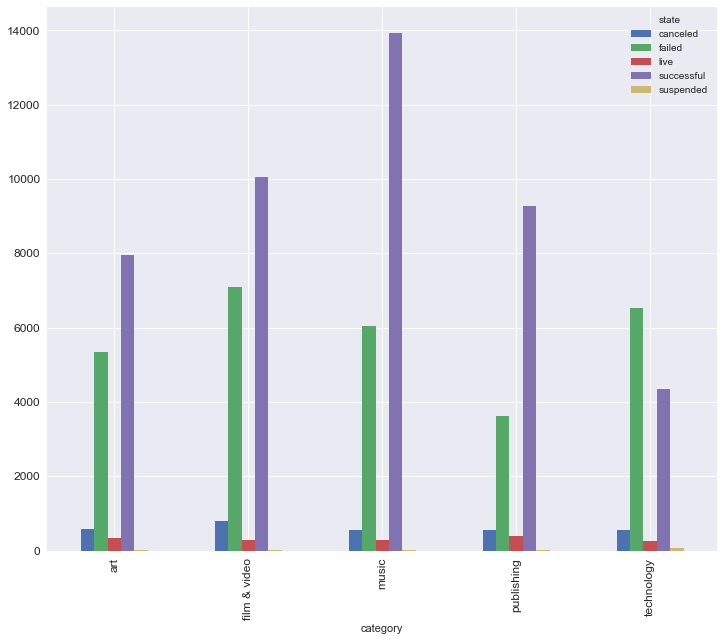

In [38]:
us_sub.groupby(['category', 'state']).size().unstack().plot(kind='bar',figsize=(12,10))

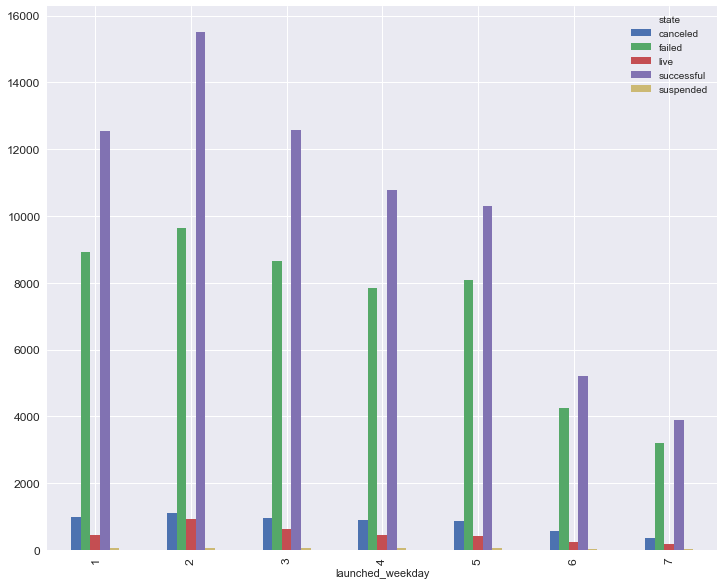

In [41]:
us.groupby(['launched_weekday', 'state']).size().unstack().plot(kind='bar',figsize=(12,10))

- Looks like musicians have better odds of success

### Spotlight and Successs, are they same?

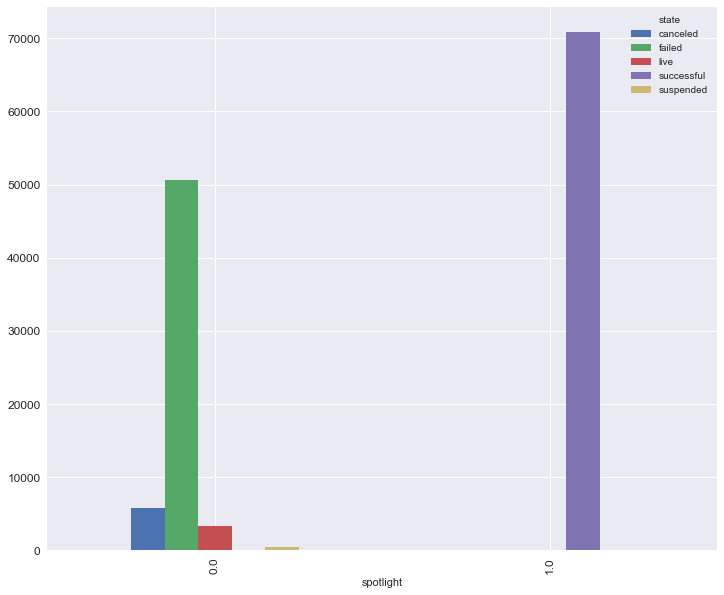

In [49]:
us.groupby(['spotlight', 'state']).size().unstack().plot(kind='bar',figsize=(12,10))

- Indeed they are

### are you backed by kickstarter

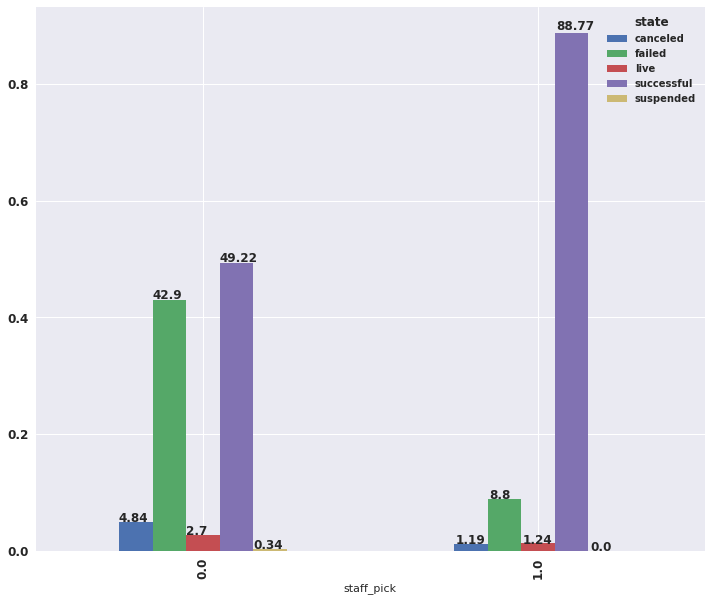

In [69]:
temp_df = us.groupby(['staff_pick', 'state']).size().unstack()
temp_df_2 = (temp_df.T/temp_df.sum(axis=1)).T
ax = temp_df_2.plot(kind='bar',figsize=(12,10))

for p in ax.patches:
    ax.annotate(str(round(p.get_height()*100,2)), (p.get_x() * 1.005, p.get_height() * 1.005))

- If you are, then you have better odds of success

### Active profiles take home the gold!

In [58]:
temp_df_2 = (temp_df.T/temp_df.sum(axis=1)).T

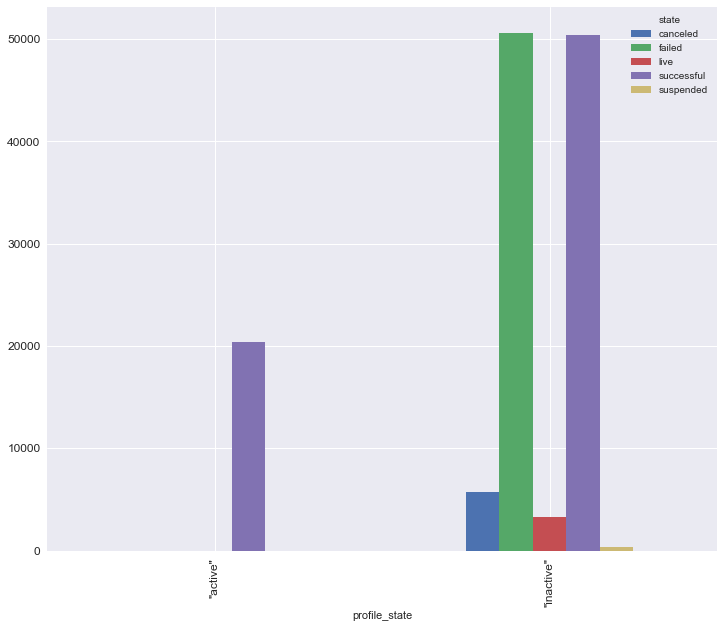

In [69]:
us.groupby(['profile_state', 'state']).size().unstack().plot(kind='bar',figsize=(12,10))

### Towns are interesting!

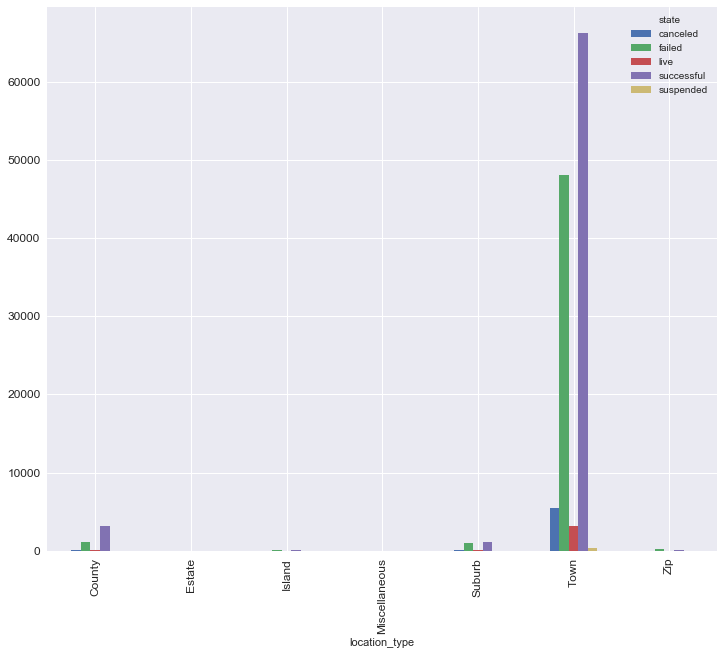

In [70]:
us.groupby(['location_type', 'state']).size().unstack().plot(kind='bar',figsize=(12,10))

### Music is indeed pleasing, and raising money!

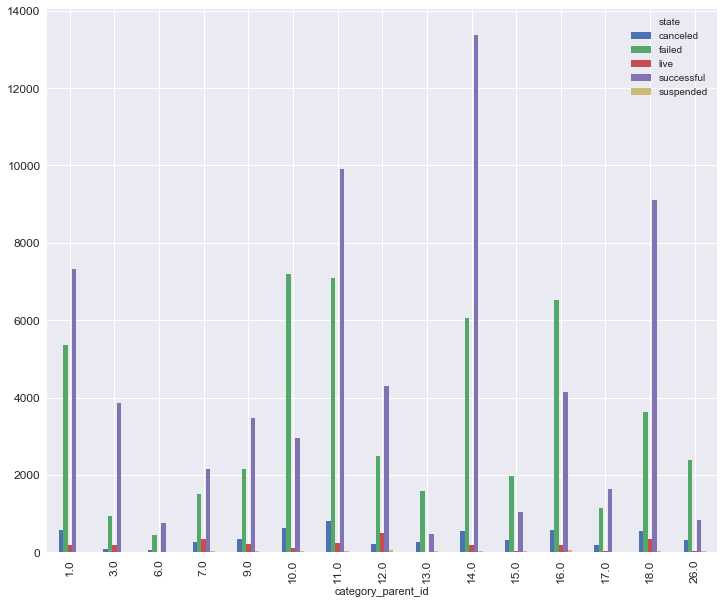

In [73]:
us.groupby(['category_parent_id', 'state']).size().unstack().plot(kind='bar',figsize=(12,10))

### Not surprising CA, NY, and TX are the top 3 states in the US

### State by Top 3 States

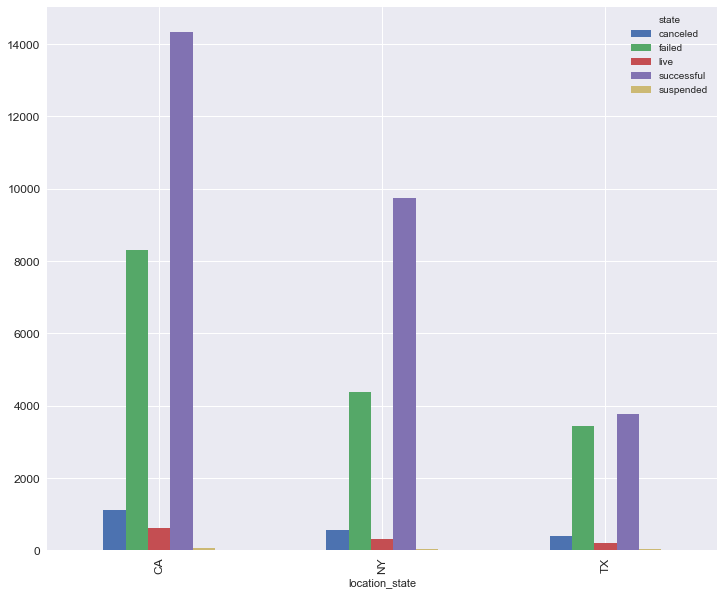

In [76]:
us[us['location_state'].isin(['CA', 'NY', 'TX'])].\
        groupby(['location_state', 'state']).size().unstack().plot(kind='bar',figsize=(12,10))

- Interestingly Texas has significant amount of failures
- What's going on there?

### Category position with state

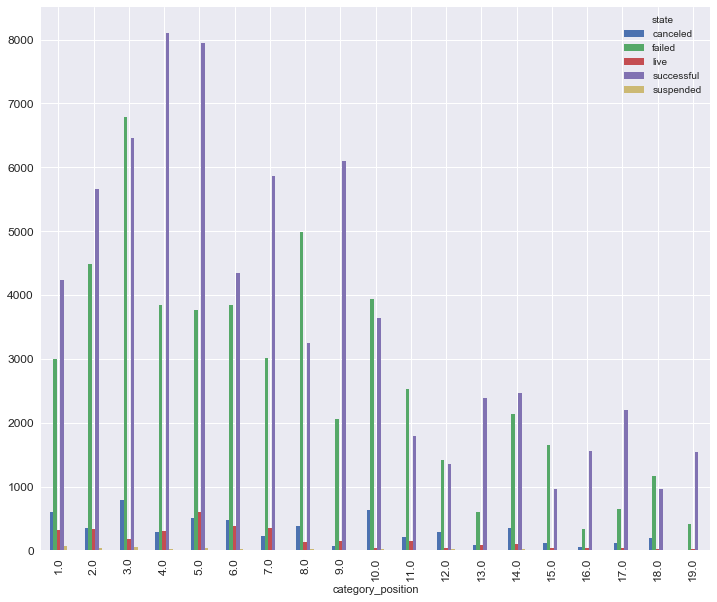

In [77]:
us.groupby(['category_position', 'state']).size().unstack().plot(kind='bar',figsize=(12,10))

- Seems to be heavily correlated with category parent

### Creators with state

In [82]:
us_creator_sub = us[us['creator_name'].isin(list(us['creator_name'].value_counts(ascending=False).index)[:10])]

In [83]:
def creator_name(name):
    return name.split(',')[0]

In [84]:
us_creator_sub['creator_name'] = us_creator_sub['creator_name'].apply(creator_name)

C:\Users\sahil\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


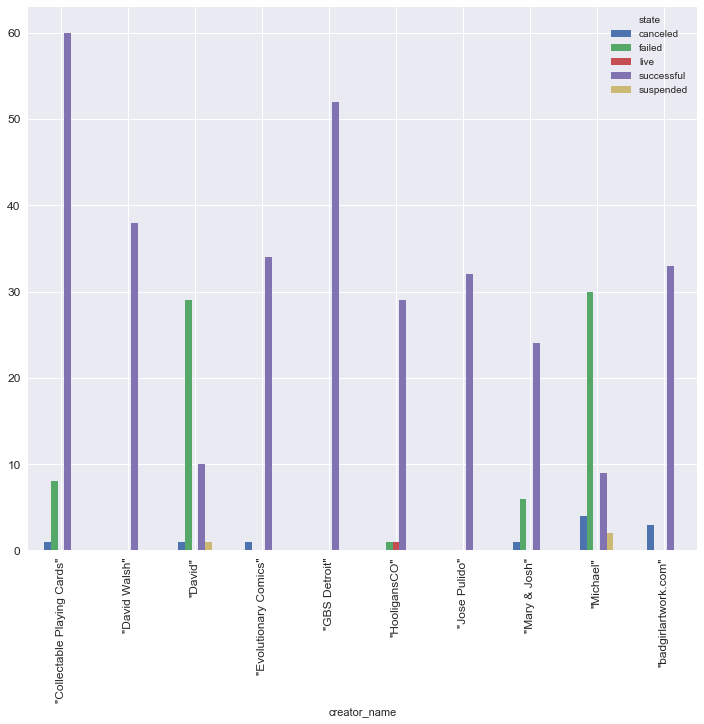

In [85]:
us_creator_sub.groupby(['creator_name', 'state']).size().unstack().plot(kind='bar',figsize=(12,10))

- It appears they do
- but not enough live projects by creator to consider them for our model

### Month and State

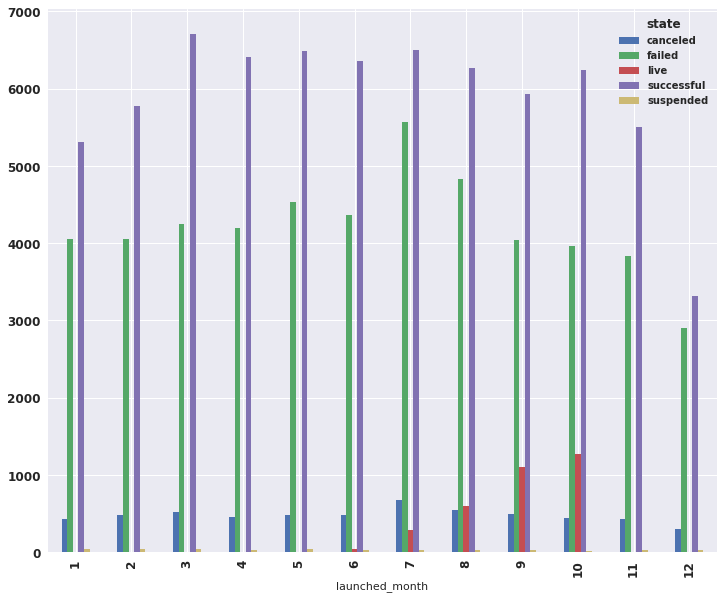

In [75]:
us.groupby(['launched_month', 'state']).size().unstack().plot(kind='bar',figsize=(12,10))

- Might be interesting
- evenly spread except for December

### Week with State

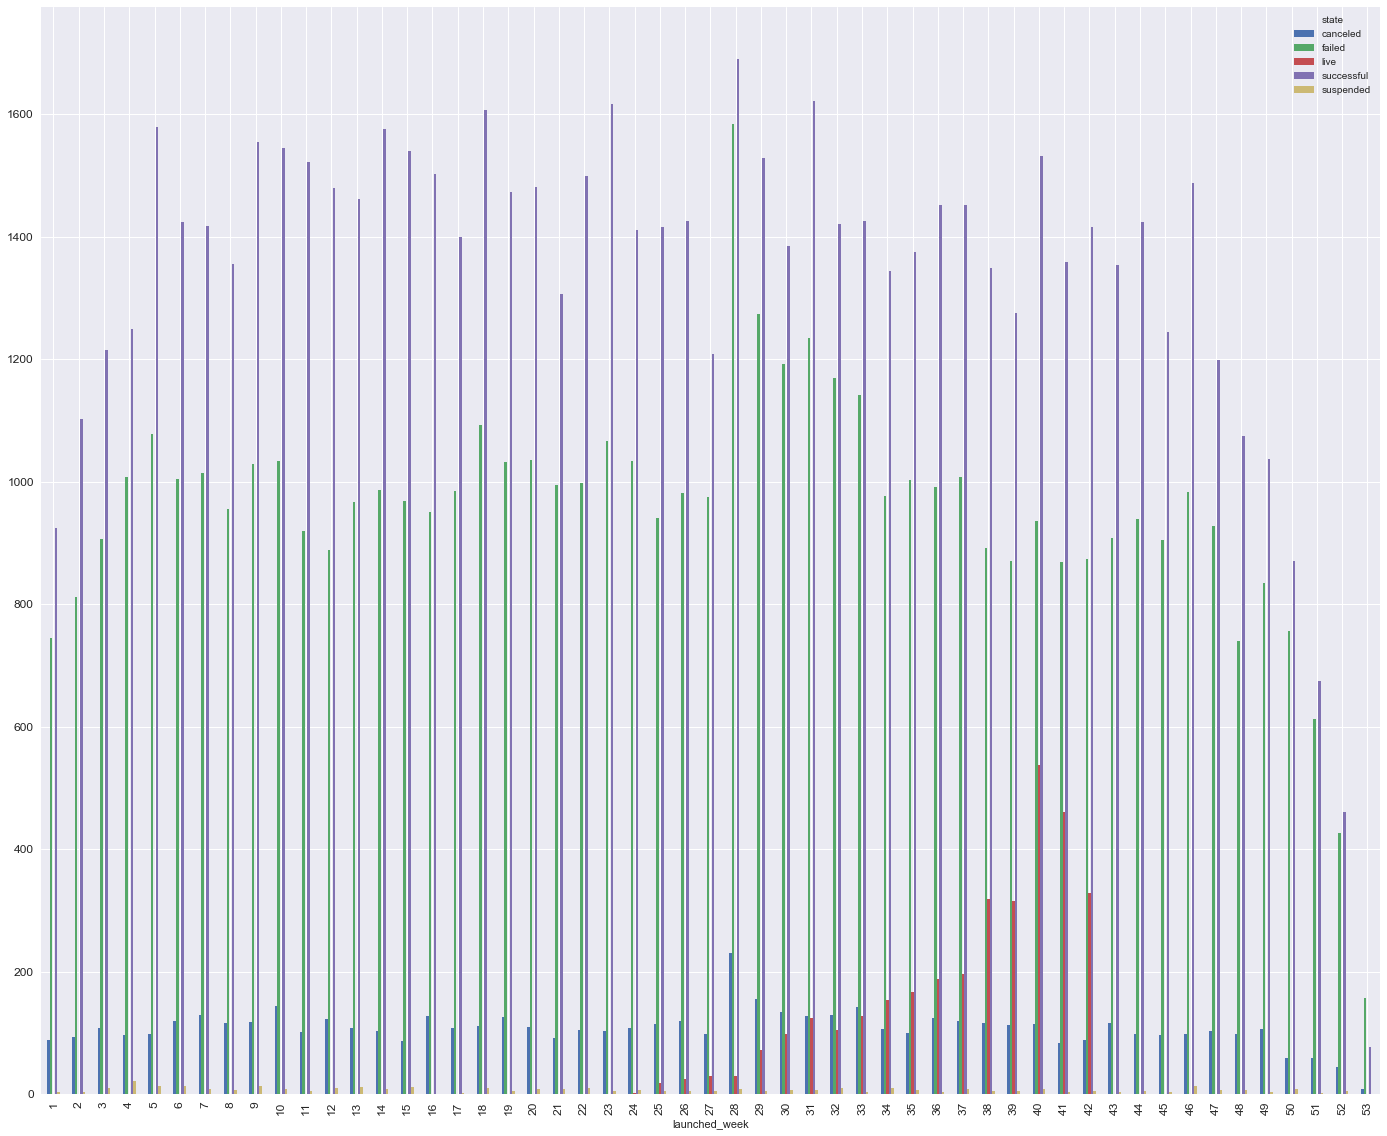

In [97]:
us.groupby(['launched_week', 'state']).size().unstack().plot(kind='bar',figsize=(24,20))

- last weeks of the year show poor results
- consistent with months

### Launch on a Week Day

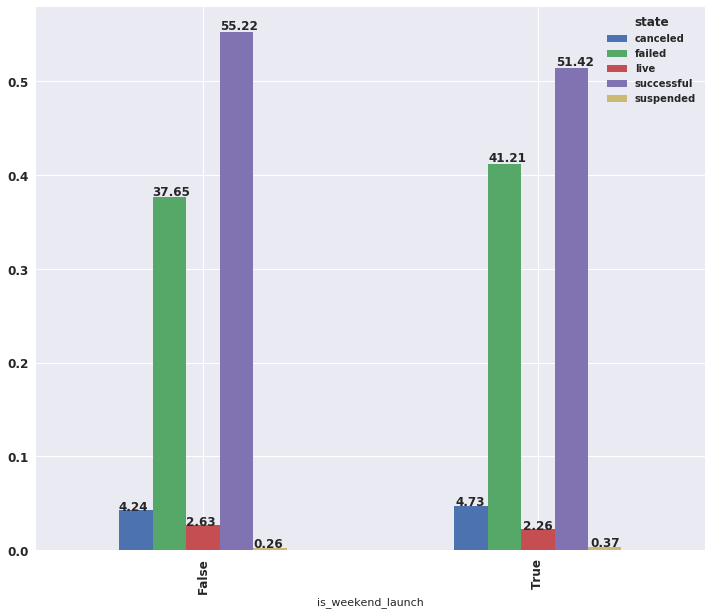

In [76]:
temp_df = us.groupby(['is_weekend_launch', 'state']).size().unstack()
temp_df_2 = (temp_df.T/temp_df.sum(axis=1)).T
ax = temp_df_2.plot(kind='bar',figsize=(12,10))

for p in ax.patches:
    ax.annotate(str(round(p.get_height()*100,2)), (p.get_x() * 1.005, p.get_height() * 1.005))

# Multivariate analysis

In [170]:
tfidf = TfidfVectorizer(max_features = 40, use_idf = True, \
                        stop_words='english', ngram_range=(1,2))

In [171]:
X = tfidf.fit_transform(us['cleaned_description'].values)

In [173]:
## append to original dataframe
# vectors_df = pd.DataFrame(X.toarray(), columns=["_"+xx for xx in vec.get_feature_names()])
# projects1_df = pd.concat([projects[features], vectors_df], axis=1)

us_vectors = pd.DataFrame(X.toarray(), columns=tfidf.get_feature_names())

# Word Cloud

In [179]:
from wordcloud import WordCloud
from nltk.corpus import stopwords

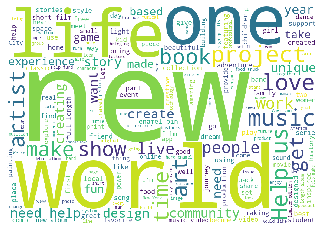

In [178]:
wc = WordCloud(
    background_color="white",
    max_words=200,
    width = 1024,
    height = 720,
    stopwords=stopwords.words("english")
)

# Generate the cloud

wc.generate(contents)

plt.imshow(wc)
plt.axis("off")
plt.show()

# Word Cloud of Successful Projects

In [180]:
successful = us[us['state'] == 'successful']

In [181]:
contents = successful['blurb'].fillna("").tolist()
contents = " ".join(contents)

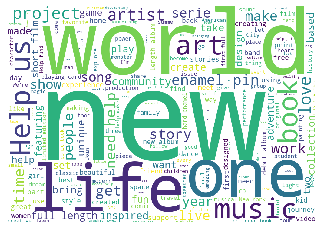

In [182]:
wc = WordCloud(
    background_color="white",
    max_words=200,
    width = 1024,
    height = 720,
    stopwords=stopwords.words("english")
)

# Generate the cloud

wc.generate(contents)

plt.imshow(wc)
plt.axis("off")
plt.show()

___

In [186]:
sizes = pd.DataFrame(us['location_state'].value_counts().reset_index().\
             rename(columns={'index':'state','location_state':'counts'}))

In [187]:
import folium

m = folium.Map(location = [42.767481,-97.951699],zoom_start=4,disable_3d=False)

m.choropleth(geo_data='../data/us_states.geojson', data=sizes,
             columns=[ 'state','counts'],
             key_on='feature.id',
             fill_color='YlOrRd', fill_opacity=0.7, line_opacity=0.8,
             legend_name='Distribution of Kickstarter Projects Across US')
folium.LayerControl().add_to(m)
m

C:\Users\sahil\Anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [130]:
## saving U.S. df
us['creator_name'] = us['creator_name'].apply(creator_name) 
us.to_csv('../data/us_kickstarter.zip', compression='zip', index=False)